## ApproxPosterior (Test Function 1: Branin and Lim)
Query efficient posterior estimation in scientific experiments via Bayesian active learning.pdf   
https://dflemin3.github.io/approxposterior/tutorial.html?highlight=estburnin   
https://github.com/j-f-paquet/parton_energy_loss_qcd_bjorken/blob/main/5parameter_estimation_with_approxposterior.ipynb

In [1]:
import numpy as np
true_param = np.array([0.2,0.8]).reshape(1,2)
prior_ranges= {'x1':(0,1), 'x2':(0,1)}
true_values= {'x1': true_param[0][0], 'x2': true_param[0][1]}

In [2]:
import emcee
from scipy.optimize import minimize
import corner
import ptemcee
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
from emukit.core import ParameterSpace, ContinuousParameter
from GPy.models import MultioutputGP
from GPy import likelihoods
from emukit.model_wrappers import GPyMultiOutputWrapper
from GPy.kern import RBF
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper

import random
seed = random.seed(42)

from emukit.experimental_design.acquisitions.contour_MultiObs_min import contourMinEI
from emukit.experimental_design.acquisitions.contour_1D import contour1D
from emukit.experimental_design import ExperimentalDesignLoop
from emukit.core.optimization import GradientAcquisitionOptimizer

from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D

from pyDOE import *
from scipy.stats import norm
from scipy import integrate
import corner

import math

from approxposterior import approx, gpUtils as gpu
import time

# set seaborn style
import seaborn as sns
sns.set_style("white")

In [3]:
# 3d plot function
def makeplot(position,x,y,z,title):
    ax = fig.add_subplot(position,projection='3d')
    ax.scatter(x, y, z, c=z, label=title)
    ax.legend()
    return ax

In [4]:
lb = [0,0]
ub = [1,1]
parameter_space = ParameterSpace([ContinuousParameter('x1', lb[0], ub[0]),ContinuousParameter('x2', lb[1], ub[1])])
pi = math.pi
a = 1
b = 5.1 / (4 * pi **2)
c = 5 / pi
r = 6
s = 10
t = 1 / (8*pi)
noise = 0.1 # statistical noise

# https://www.sfu.ca/~ssurjano/limetal02non.html
# https://www.sfu.ca/~ssurjano/branin.html

def f(X): # with statistical noise
    y1 = 1/6 * ((30+5*X[:,0]*np.sin(5*X[:,0])) * (4+np.exp(-5*X[:,1]))-100) +  np.random.normal(0,noise,X.shape[0])
    y2 = a * (X[:,1] - b * X[:,0]**2 + c * X[:,0] - r)**2 + s*(1-t) * np.cos(X[:,0]) + s +  np.random.normal(0,noise,X.shape[0])
    return [y1.reshape(-1,1),y2.reshape(-1,1)]

def f_noNoise(X): # noise-free
    y1 = 1/6 * ((30+5*X[:,0]*np.sin(5*X[:,0])) * (4+np.exp(-5*X[:,1]))-100)
    y2 = a * (X[:,1] - b * X[:,0]**2 + c * X[:,0] - r)**2 + s*(1-t) * np.cos(X[:,0]) + s
    return [y1.reshape(-1,1),y2.reshape(-1,1)]

#### Read in experimental data

In [5]:
y_exp = np.array(pd.read_csv('Experimental Data/TF1_ExpData.txt', delimiter=' ', header=None))
dy_exp = np.array(pd.read_csv('Experimental Data/TF1_dyExpData.txt', delimiter=' ', header=None)).flatten()

#### Define prior, likelihood (using simulator) and uniform sampling function

In [6]:
theta_min = 0
theta_max = 1
ndim = 2

# independent uniform prior
def log_flat_prior(theta):
    # The parameters are stored as a vector of values, so unpack them
    theta1, theta2 = theta
    # We're using only uniform priors in [0,1]
    if (theta_min <= theta1) and (theta1 <= theta_max) and (theta_min <= theta2) and (theta2 <= theta_max):
        return 0. # log(1)
    else:
        return -np.inf  # log(0)
    
# log_flat_prior = np.vectorize(log_flat_prior)

def sim_output(xx, obsno):
    """This generates output from simulator."""
    X = xx.reshape(-1, ndim)
    y = f(X)[obsno] # use simulator to evaluate likelihood
    return y

# define log likelihood
def log_likelihood_sim(theta, y_exp, dy_exp):
    '''
    Log-likelihood for data y_exp.
    theta: 2d vector;
    y_exp: n_exp by 2;
    dy_exp: 2d vector (experimental noise is the same for different observations).
    '''
    log_lik = 0
    for obs in range(y_exp.shape[1]): # number of observables
        y_pred = sim_output(theta, obs) # simulator (the same value for one input theta)
        sigma2 = dy_exp[obs]**2. + 0 # no simulator uncertainty
        log_lik = log_lik - 0.5*np.log(2.*np.pi*sigma2) - 0.5/sigma2 * np.sum((y_pred - y_exp[:,obs])**2)    
    return log_lik

#posterior using flat prior
def log_posterior_flat_prior_sim(theta, y_exp, dy_exp):
    '''Log posterior for data y_exp and uncertainties 
        dy_exp given parameter array theta, assuming prior is flat.'''
    return log_flat_prior(theta) + log_likelihood_sim(theta, y_exp, dy_exp)

In [7]:
dy_exp

array([0.1, 0.1])

In [8]:
# Visualize the log posterior...



In [9]:
def sampleFunction(n):
    """
    docs

    Parameters
    ----------
    n : int
        Number of samples

    Returns
    -------
    sample : floats
        n x 2 array of floats samples from the prior (uniform)
    """

    # Sample model parameters given prior distributions
    return np.array([np.random.uniform(size=(n)),np.random.uniform(size=(n))]).T

#### Define Approxposterior parameters: how to set parameters?

In [10]:
# Define algorithm parameters
m0 = 20                          # Initial size of training set
m = 1                            # Number of new points to find each iteration
nmax = 15                         # Maximum number of iterations
#prior_ranges= {'x1':(0,0.5), 'x2':(0.5,1)}
prior_ranges= {'x1':(0,1), 'x2':(0,1)}
bounds = list(prior_ranges.values())    # Prior bounds
algorithm = "bape"                # Use the Kandasamy et al. (2017) formalism

# emcee MCMC parameters: Use the same MCMC parameters as the emcee-only analysis
initial_state = np.ones(shape=(2,20))
initial_state[0,:] = initial_state[0,:] * true_param[0,0] + np.random.normal(0, 0.001, size=(20))
initial_state[1,:] = initial_state[1,:] * true_param[0,1] + np.random.normal(0, 0.001, size=(20))
samplerKwargs = {"nwalkers" : 20}  # emcee.EnsembleSampler parameters
#mcmcKwargs = {"iterations" : 5000, 'initial_state':initial_state.T} # emcee.EnsembleSampler.run_mcmc parameters
mcmcKwargs = {"iterations" : 5000} # emcee.EnsembleSampler.run_mcmc parameters


# Data and uncertainties that we use to condition our model
args = [y_exp, dy_exp]

Run ApproxPosterior

In [11]:
initial_state

array([[0.20218576, 0.20081275, 0.19868543, 0.19910294, 0.20065968,
        0.19993876, 0.20096456, 0.1998995 , 0.20074203, 0.19996721,
        0.1994471 , 0.19933547, 0.20025522, 0.19916745, 0.20015663,
        0.19952914, 0.20154262, 0.19938029, 0.20028683, 0.20012774],
       [0.79854753, 0.79975305, 0.79910801, 0.79743433, 0.7998083 ,
        0.8006204 , 0.80064346, 0.79931019, 0.80018962, 0.80097914,
        0.80143055, 0.79900201, 0.80180504, 0.79898938, 0.80081588,
        0.79946079, 0.8002085 , 0.79892332, 0.80071927, 0.80016993]])

  0%|          | 0/1 [00:00<?, ?it/s]

Iteration: 0


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/approxposterior-0.4-py3.6.egg/approxposterior/utility.py:352: OptimizeWarning:Unknown solver options: bounds


hyperparameters [-3.42194135e+04 -3.94978728e+00 -2.86095967e+00]


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration: 1
hyperparameters [-3.41615351e+04 -3.96125733e+00 -2.86831693e+00]


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration: 2
hyperparameters [-3.26603910e+04 -3.87891292e+00 -2.82643931e+00]


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration: 3
hyperparameters [-3.25246702e+04 -3.87693072e+00 -2.82235416e+00]


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration: 4
hyperparameters [-3.25512279e+04 -3.88264790e+00 -2.82759697e+00]


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration: 5
hyperparameters [-3.26332831e+04 -3.82597820e+00 -2.81024787e+00]


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration: 6
hyperparameters [-3.27309298e+04 -3.83036665e+00 -2.80344250e+00]


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration: 7
hyperparameters [-3.27316880e+04 -3.82991952e+00 -2.80314618e+00]


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration: 8
hyperparameters [-3.26998870e+04 -3.83537777e+00 -2.80362362e+00]


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration: 9
hyperparameters [-3.24994028e+04 -3.88782774e+00 -2.82041198e+00]


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration: 10
hyperparameters [-3.25129181e+04 -3.88410292e+00 -2.81944438e+00]


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration: 11
hyperparameters [-3.25425346e+04 -3.87606225e+00 -2.81739824e+00]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning:invalid value encountered in double_scalars
  0%|          | 0/1 [00:00<?, ?it/s]

Iteration: 12
hyperparameters [-3.25629765e+04 -3.87071207e+00 -2.81612644e+00]


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration: 13
hyperparameters [-3.25841034e+04 -3.86534829e+00 -2.81510123e+00]


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration: 14
hyperparameters [-3.25402130e+04 -3.87646316e+00 -2.81550938e+00]


100%|██████████| 1/1 [00:03<00:00,  3.73s/it]


Defaulting to nwalkers samples from priorSample.
mcmc finished
burn-in estimate: 64
thin estimate: 13
(5000, 20, 2)


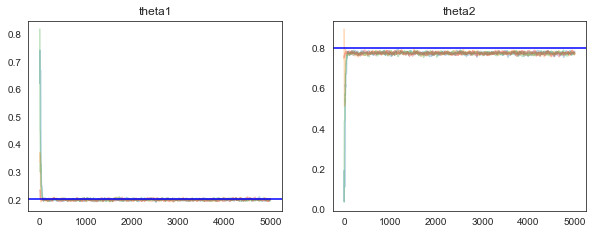

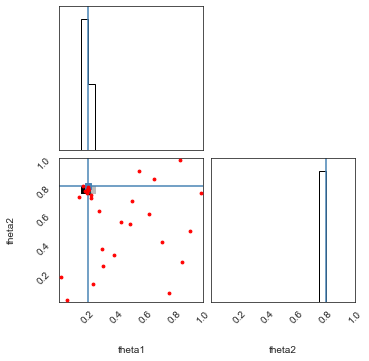

In [12]:
for runNo in range(1):
    #---# Start with a random LHD and train GP on log posterior
    # theta = np.array(sampleFunction(m0))
    theta = lhs(n=2, samples=m0)

    # Evaluate forward model to compute log likelihood + lnprior for each theta
    y = list()
    for ii in range(len(theta)):
        y.append((log_likelihood_sim(theta[ii,:], *args) + log_flat_prior(theta[ii,:])))
    y = np.array(y)

    # initialize GP
    gp = gpu.defaultGP(theta, y, white_noise=-12)
    
    #---# Approxposterior
    ap = approx.ApproxPosterior(theta=theta,                   # Initial model parameters for inputs
                            y=y,                           # Logprobability of each input
                            gp=gp,                         # Initialize Gaussian Process
                            lnprior=log_flat_prior,              # logprior function
                            lnlike=log_likelihood_sim,          # loglikelihood function
                            priorSample=sampleFunction,    # Prior sample function
                            algorithm=algorithm,           # bape, agp, or alternate
                            bounds=bounds)                  # Parameter bounds
    
    # run
    ap.run(m=m, nmax=nmax,estBurnin=True, mcmcKwargs=mcmcKwargs, cache=False,
           samplerKwargs=samplerKwargs, verbose=True, args=args,onlyLastMCMC=True,
           seed=seed, optGPEveryN = 1, # re-optimize the GP hyperparameters for every new design point
           thinChains=True, nGPRestarts = 50, nMinObjRestarts = 100, convergenceCheck=False,
          minObjOptions={'bounds':bounds,'adaptive':True})
    
    # extract samples
    #sample_temp = ap.sampler.get_chain(discard=ap.iburns[-1], flat=False, thin=ap.ithins[-1])
    sample_temp = ap.sampler.get_chain(flat=False)


    print(sample_temp.shape)
    # save samples for R analysis
    # plots & save data for R analysis
    #approx_chain = sample_temp[-2000:,:] # keep last 2000 samples, same as MCMC, LHD and RJ2016
    approx_chain = sample_temp
    fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(10,3.5))
    ax1.plot(approx_chain[:,0,0], '-', label='chain1', alpha=0.3)
    ax1.plot(approx_chain[:,5,0], '-', label='chain2', alpha=0.3)
    ax1.plot(approx_chain[:,13,0], '-', label='chain3', alpha=0.3)
    ax1.plot(approx_chain[:,17,0], '-', label='chain4', alpha=0.3)
    ax1.axhline(y=true_param[0][0], color='blue')
    ax1.title.set_text('theta1')

    #ax2.plot(approx_chain[-2000:,0,1], '-', color='k', alpha=0.3)
    ax2.plot(approx_chain[:,0,1], '-', label='chain1', alpha=0.3)
    ax2.plot(approx_chain[:,5,1], '-', label='chain2', alpha=0.3)
    ax2.plot(approx_chain[:,13,1], '-', label='chain3', alpha=0.3)
    ax2.plot(approx_chain[:,17,1], '-', label='chain4', alpha=0.3)
    ax2.axhline(y=true_param[0][1], color='blue')
    ax2.title.set_text('theta2')
    plt.show()
    approx_chain = sample_temp[-2000:,:].reshape(-1,2)
    tmp = corner.corner(approx_chain, labels=['theta1','theta2'], range=[(0.0,1),(0.0,1)],
                    truths=[true_param[0][0],true_param[0][1]])
    tmp.axes[2].scatter(ap.theta[:,0], ap.theta[:,1], s=8, color="red", zorder=20)
    plt.show()

    Approx_sim = pd.DataFrame(approx_chain)
    Approx_sim.to_csv('Outputs/TF1_MCMCApproxpost_init'+str(m0)+'_seq'+str(nmax-m0)+'.csv', index=False)


In [13]:
import ptemcee as pt
from multiprocessing import Pool

# mu is actually the posterior. But since we use flat priors it is same as the likelihood up
# to some normalization. 
def log_like_for_ptemcee(theta):
    mu,lnprior = ap._gpll(theta)
    return mu

ntemps = 50
Tmax = 100

nwalkers = 20 #guidance is 10*d
ndim = 2
#nburnin = 2000
#niterations= 5000
nthin = 1#0 # only record every nthin iteration

nburnin = 100
niterations = 500

sample_pt = pt.Sampler(nwalkers = nwalkers, ntemps = ntemps, dim = ndim, logl = log_like_for_ptemcee, logp = log_flat_prior, pool = Pool(5))

starting_guesses = np.array(list(prior_ranges.values()))[:,0] + (np.array(list(prior_ranges.values()))[:,1] - np.array(list(prior_ranges.values()))[:,0]) * np.random.rand(ntemps, nwalkers, ndim)
print(starting_guesses.shape)

print("Running burn-in phase")
for p, lnprob, lnlike in sample_pt.sample(starting_guesses, iterations=nburnin):
    pass
sample_pt.reset()
print("Running MCMC chains")
#Now we sample for nwalkers*niterations, recording every nthin-th sample:
for p, lnprob, lnlike in sample_pt.sample(p, iterations=niterations, thin=nthin,adapt=True):
    pass 

print('Done MCMC')
mean_acc_frac = np.mean(sample_pt.acceptance_fraction)
print(f"Mean acceptance fraction: {mean_acc_frac:.3f}",
      f"(in total {nwalkers*niterations} steps)")

chain = sample_pt.chain[0, :, :, :].reshape((-1, ndim))
print(chain.shape)



(50, 20, 2)
Running burn-in phase
Running MCMC chains
Done MCMC
Mean acceptance fraction: 0.559 (in total 10000 steps)
(10000, 2)


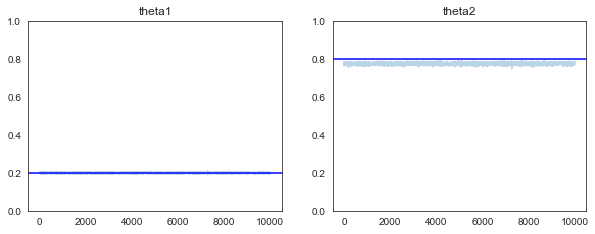

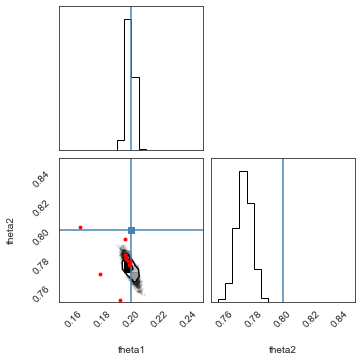

In [16]:
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(10,3.5))
ax1.plot(chain[:,0], '-', label='chain1', alpha=0.3)
ax1.axhline(y=true_param[0][0], color='blue')
ax1.set_ylim(0,1)
ax1.title.set_text('theta1')

ax2.plot(chain[:,1], '-', label='chain1', alpha=0.3)
ax2.axhline(y=true_param[0][1], color='blue')
ax2.title.set_text('theta2')
ax2.set_ylim(0,1)
plt.show()
tmp = corner.corner(chain, labels=['theta1','theta2'], range=[(0.15,0.25),(0.75,0.85)],
                truths=[true_param[0][0],true_param[0][1]])
tmp.axes[2].scatter(ap.theta[:,0], ap.theta[:,1], s=8, color="red", zorder=20)
plt.show()

In [15]:
## Put here the PTEMCEE sampling scheme....